In [2]:
from brepmatching.data import BRepMatchingDataset, load_data
from brepmatching.visualization import show_image, render_predictions
import torch
import os
from torch_geometric.data.batch import Batch
import os
from tqdm import tqdm
from brepmatching.utils import *

c:\Users\Ben\anaconda3\envs\brepmatching\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
c:\Users\Ben\anaconda3\envs\brepmatching\lib\site-packages\pyglet\libs\win32\__init__.py:326: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")


In [3]:
if os.path.exists('../data/geo_test_set.pt'):
    geo_test_graphs = torch.load('../data/geo_test_set.pt')
    topo_test_graphs = torch.load( '../data/topo_test_set.pt')
    both_test_graphs = torch.load( '../data/both_test_set.pt')
else:
    print('Loading Geo')
    geo_cache = torch.load('../data/Geo.pt')
    print('Loading Topo')
    topo_cache = torch.load('../data/Topo.pt')
    print('Loading Both')
    both_cache = torch.load('../data/TopoAndGeo.pt')

    for i in tqdm(range(len(geo_cache['preprocessed_data']))):
        geo_cache['preprocessed_data'][i].__node_sets__.add('bl_overlap_larger_face_percentages')
        geo_cache['preprocessed_data'][i].__node_sets__.add('bl_overlap_larger_edge_percentages')
        geo_cache['preprocessed_data'][i].__node_sets__.add('bl_overlap_smaller_face_percentages')
        geo_cache['preprocessed_data'][i].__node_sets__.add('bl_overlap_smaller_edge_percentages')
    
    for i in tqdm(range(len(topo_cache['preprocessed_data']))):
        topo_cache['preprocessed_data'][i].__node_sets__.add('bl_overlap_larger_face_percentages')
        topo_cache['preprocessed_data'][i].__node_sets__.add('bl_overlap_larger_edge_percentages')
        topo_cache['preprocessed_data'][i].__node_sets__.add('bl_overlap_smaller_face_percentages')
        topo_cache['preprocessed_data'][i].__node_sets__.add('bl_overlap_smaller_edge_percentages')
    
    for i in tqdm(range(len(both_cache['preprocessed_data']))):
        both_cache['preprocessed_data'][i].__node_sets__.add('bl_overlap_larger_face_percentages')
        both_cache['preprocessed_data'][i].__node_sets__.add('bl_overlap_larger_edge_percentages')
        both_cache['preprocessed_data'][i].__node_sets__.add('bl_overlap_smaller_face_percentages')
        both_cache['preprocessed_data'][i].__node_sets__.add('bl_overlap_smaller_edge_percentages')

    ds_geo = BRepMatchingDataset(geo_cache,mode='test',require_onshape_matchings=True)
    ds_topo = BRepMatchingDataset(topo_cache,mode='test',require_onshape_matchings=True)
    ds_both = BRepMatchingDataset(both_cache,mode='test',require_onshape_matchings=True)

    geo_test_graphs = [ds_geo[i] for i in range(len(ds_geo))]
    topo_test_graphs = [ds_topo[i] for i in range(len(ds_topo))]
    both_test_graphs = [ds_both[i] for i in range(len(ds_both))]
    
    torch.save(geo_test_graphs, '../data/geo_test_set.pt')
    torch.save(topo_test_graphs, '../data/topo_test_set.pt')
    torch.save(both_test_graphs, '../data/both_test_set.pt')

In [4]:
geo_union_cache = torch.load('../data/GeoUnion.pt')

In [7]:
ds_geo_union = BRepMatchingDataset(geo_union_cache,mode='test',require_onshape_matchings=True)
geo_union_test_graphs = [ds_geo_union[i] for i in range(len(ds_geo_union))]

In [11]:
extra_overlaps = []
for i in tqdm(range(len(geo_test_graphs))):
    ex = geo_test_graphs[i]

    overlap_matches = {tuple(x) for x in ex.bl_overlap_faces_matches.T.tolist()}
    onshape_matches = {tuple(x) for x in ex.os_bl_faces_matches.T.tolist()}

    extra_overlaps.append(len(overlap_matches - onshape_matches))

extra_union_overlaps = []
for i in tqdm(range(len(geo_union_test_graphs))):
    ex = geo_union_test_graphs[i]

    overlap_matches = {tuple(x) for x in ex.bl_overlap_faces_matches.T.tolist()}
    onshape_matches = {tuple(x) for x in ex.os_bl_faces_matches.T.tolist()}

    extra_union_overlaps.append(len(overlap_matches - onshape_matches))

100%|██████████| 682/682 [00:00<00:00, 42625.55it/s]


In [18]:
extra_union_overlaps

[2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 4,
 3,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


(array([492., 132.,  22.,  12.,   9.,   5.,   4.,   0.,   0.,   3.]),
 array([ 0. ,  8.2, 16.4, 24.6, 32.8, 41. , 49.2, 57.4, 65.6, 73.8, 82. ]),
 <BarContainer object of 10 artists>)

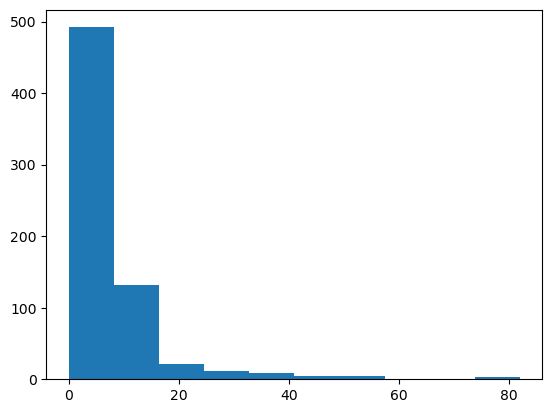

In [12]:
plt.hist(extra_overlaps)

(array([578.,  51.,  21.,  10.,   6.,   4.,   7.,   1.,   3.,   1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

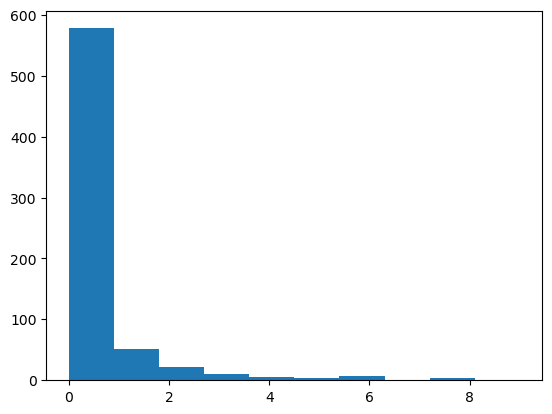

In [13]:
plt.hist(extra_union_overlaps)

In [ ]:
ex.bl_overlap_smaller_face_percentages

In [20]:
ex = geo_union_test_graphs[0]

overlap_matches = {tuple(x) for x in ex.bl_overlap_faces_matches.T.tolist()}
onshape_matches = {tuple(x) for x in ex.os_bl_faces_matches.T.tolist()}

overlap_matches - onshape_matches

{(15, 13), (17, 14)}

In [45]:
for i in tqdm(range(len(geo_union_test_graphs))):
    ex = geo_union_test_graphs[i]
    if (ex.bl_overlap_smaller_face_percentages > 1.001).any():
        break
    

 50%|█████     | 343/682 [00:00<00:00, 57204.91it/s]


In [51]:
ex.bl_overlap_smaller_face_percentages

tensor([0.9757, 0.9034, 1.0000, 0.9995, 0.9856, 0.9275, 1.0000, 1.0000, 1.0000,
        0.9275, 0.9924, 0.9956, 0.8572, 1.2312, 1.2312])

In [48]:
overlap_matches = {tuple(x) for x in ex.bl_overlap_faces_matches.T.tolist()}
onshape_matches = {tuple(x) for x in ex.os_bl_faces_matches.T.tolist()}

overlap_matches - onshape_matches

{(22, 22),
 (24, 24),
 (30, 30),
 (32, 31),
 (33, 31),
 (34, 31),
 (35, 31),
 (38, 34),
 (41, 37)}

In [49]:
ex.bl_overlap_faces_matches

tensor([[11, 19, 22, 24, 30, 31, 32, 33, 34, 35, 38, 41, 47, 49, 53],
        [11, 19, 22, 24, 30, 31, 31, 31, 31, 31, 34, 37, 39, 41, 45]])

In [55]:
ex.n_onshape_baseline_unmatched

tensor([0])

In [21]:
import meshplot as mp

In [22]:
ex.left_F_to_faces.shape

torch.Size([1, 164])

In [23]:
ex.left_V.shape

torch.Size([84, 3])

In [53]:
mp.plot(ex.left_V.numpy(), ex.left_F.T.numpy(), c =(ex.left_F_to_faces.flatten() == 22).numpy().astype(int), return_plot=True).add_mesh(ex.right_V.numpy() + np.array([.1,0.,0.]), ex.right_F.T.numpy(), c =(ex.right_F_to_faces.flatten() == 22).numpy().astype(int))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.00…

1

In [ ]:
ex

In [14]:
follow_batch=['left_vertices','right_vertices','left_edges', 'right_edges','left_faces','right_faces', 'faces_matches', 'edges_matches', 'vertices_matches']
geo_batch = Batch.from_data_list(geo_test_graphs,follow_batch=follow_batch)
geo_union_batch = Batch.from_data_list(geo_union_test_graphs,follow_batch=follow_batch)
topo_batch = Batch.from_data_list(topo_test_graphs,follow_batch=follow_batch)
both_batch = Batch.from_data_list(both_test_graphs,follow_batch=follow_batch)

In [ ]:
geo_batch['bl_overlap_faces_matches'][:,geo_batch.bl_overlap_smaller_face_percentages >= .9]

In [15]:
def compute_metrics_from_batch(batch, small_overlap_thresh=.8, large_overlap_thresh = .0):
    face_exact_metrics = compute_metrics_from_matches(batch, 'faces', batch['bl_exact_faces_matches'])
    edge_exact_metrics = compute_metrics_from_matches(batch, 'edges', batch['bl_exact_edges_matches'])
    vert_exact_metrics = compute_metrics_from_matches(batch, 'vertices', batch['bl_exact_vertices_matches'])

    face_overlap = batch.bl_overlap_faces_matches[:,(batch.bl_overlap_smaller_face_percentages >= small_overlap_thresh) & (batch.bl_overlap_larger_face_percentages >= large_overlap_thresh)]
    edge_overlap = batch.bl_overlap_edges_matches[:,(batch.bl_overlap_smaller_edge_percentages >= small_overlap_thresh) & (batch.bl_overlap_larger_edge_percentages >= large_overlap_thresh)]


    face_coincidence = torch.cat([batch['bl_exact_faces_matches'], face_overlap], dim=1)
    edge_coincidence = torch.cat([batch['bl_exact_edges_matches'], edge_overlap], dim=1)
    vert_coincidence = batch['bl_exact_vertices_matches']

    face_coincidence_metrics = compute_metrics_from_matches(batch, 'faces', face_coincidence)
    edge_coincidence_metrics = compute_metrics_from_matches(batch, 'edges', edge_coincidence)
    vert_coincidence_metrics = compute_metrics_from_matches(batch, 'vertices', vert_coincidence)

    face_onshape_metrics = compute_metrics_from_matches(batch, 'faces', batch['os_bl_faces_matches'])
    edge_onshape_metrics = compute_metrics_from_matches(batch, 'edges', batch['os_bl_edges_matches'])
    vert_onshape_metrics = compute_metrics_from_matches(batch, 'vertices', batch['os_bl_vertices_matches'])

    metrics = {
        'exact': {
            'faces': face_exact_metrics,
            'edges': edge_exact_metrics,
            'vertices': vert_exact_metrics
        },
        'coincidence': {
            'faces': face_coincidence_metrics,
            'edges': edge_coincidence_metrics,
            'vertices': vert_coincidence_metrics
        },
        'onshape': {
            'faces': face_onshape_metrics,
            'edges': edge_onshape_metrics,
            'vertices': vert_onshape_metrics
        }
    }

    return metrics

In [16]:
all_metrics = {
    'geo': compute_metrics_from_batch(geo_batch),
    'geo_union': compute_metrics_from_batch(geo_union_batch),
    'topo': compute_metrics_from_batch(topo_batch),
    'both': compute_metrics_from_batch(both_batch)
}

In [ ]:
torch.save(all_metrics, 'baseline_metrics.pt')

In [ ]:

def generate_plots(geo_test_graphs, topo_test_graphs, both_test_graphs, outdir, match_prefix='', title_prefix=''):
    for name,test_set in tqdm((('Geo',geo_test_graphs), ('Topo', topo_test_graphs), ('Both', both_test_graphs)),'Test Sets'):
        follow_batch=['left_vertices','right_vertices','left_edges', 'right_edges','left_faces','right_faces', 'faces_matches', 'edges_matches', 'vertices_matches']
        big_batch = Batch.from_data_list(test_set,follow_batch=follow_batch)
        for topo_type in tqdm(['faces', 'edges', 'vertices'],'Match Sets', leave=False):
            metrics = compute_metrics_from_matches(big_batch, topo_type, big_batch[f'bl_exact_{topo_type}_matches'])
            plot = plot_the_fives(*np.stack([metrics]*2)[:,:-2].T, np.array([0.0,1.0]),f'Exact Matching {name} ({topo_type})')
            outpath = os.path.join(outdir, f'{name}_{topo_type}.png')
            make_containing_dir(outpath)
            plot.savefig(outpath)


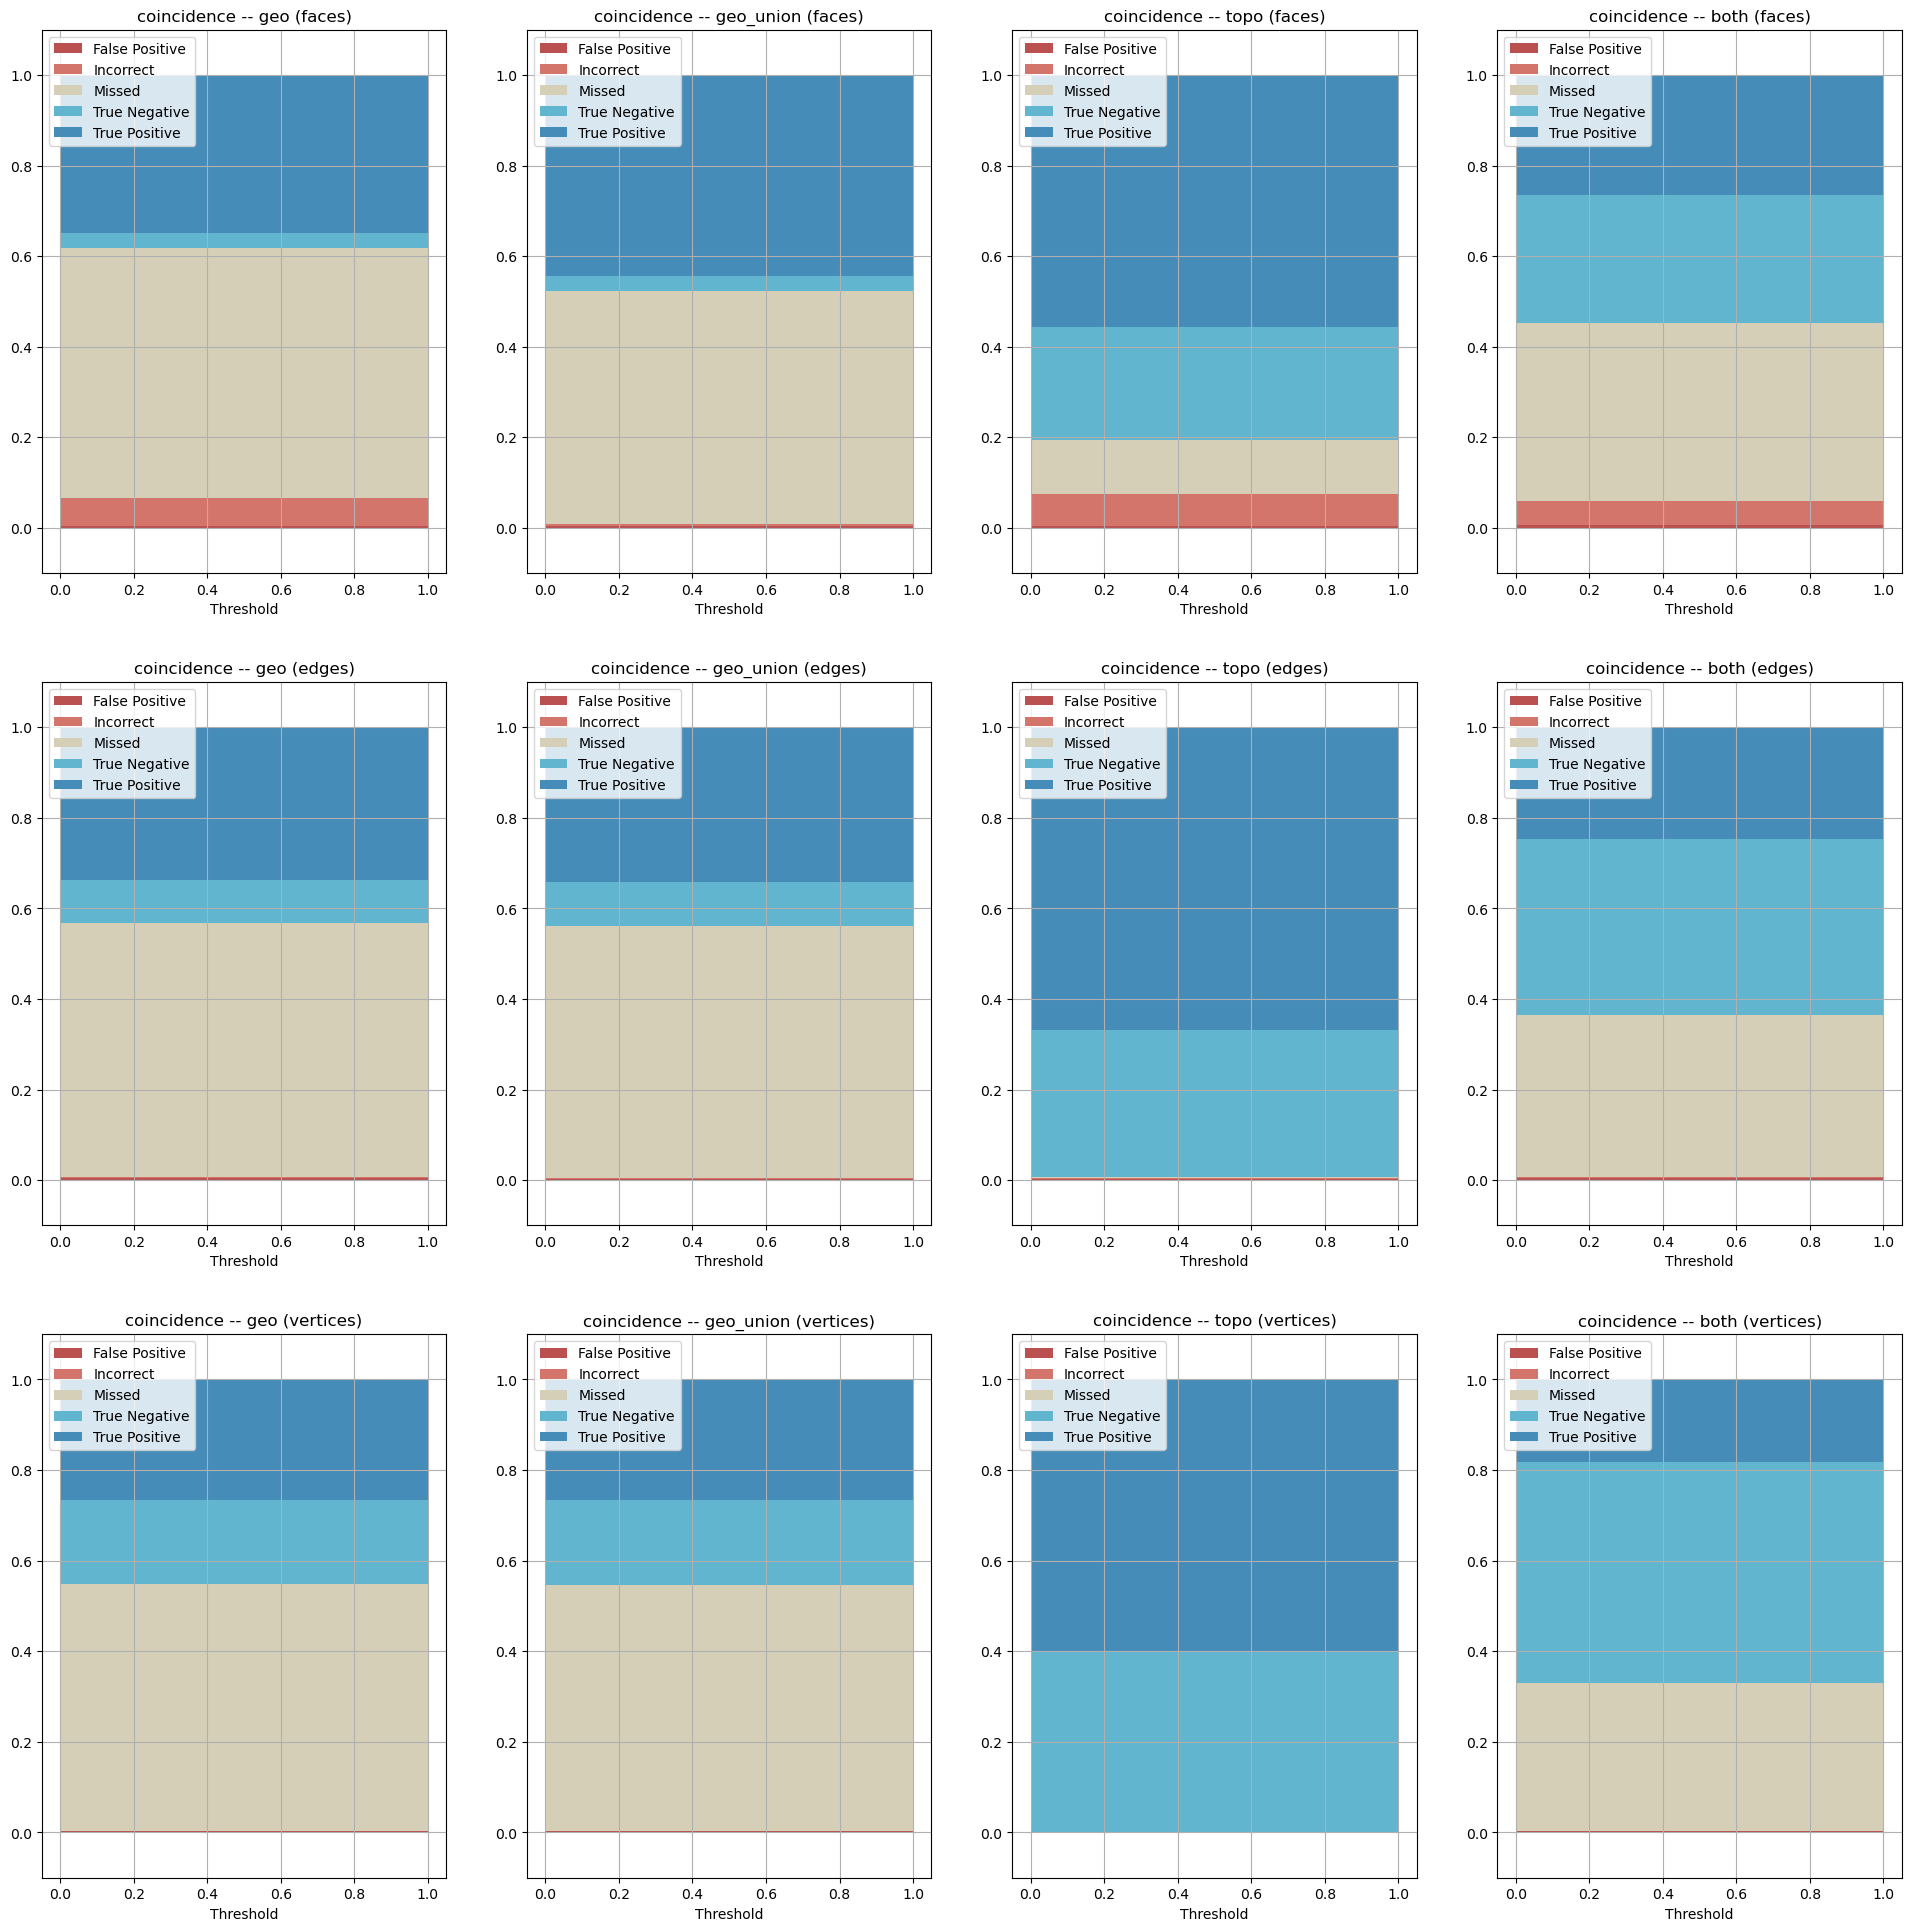

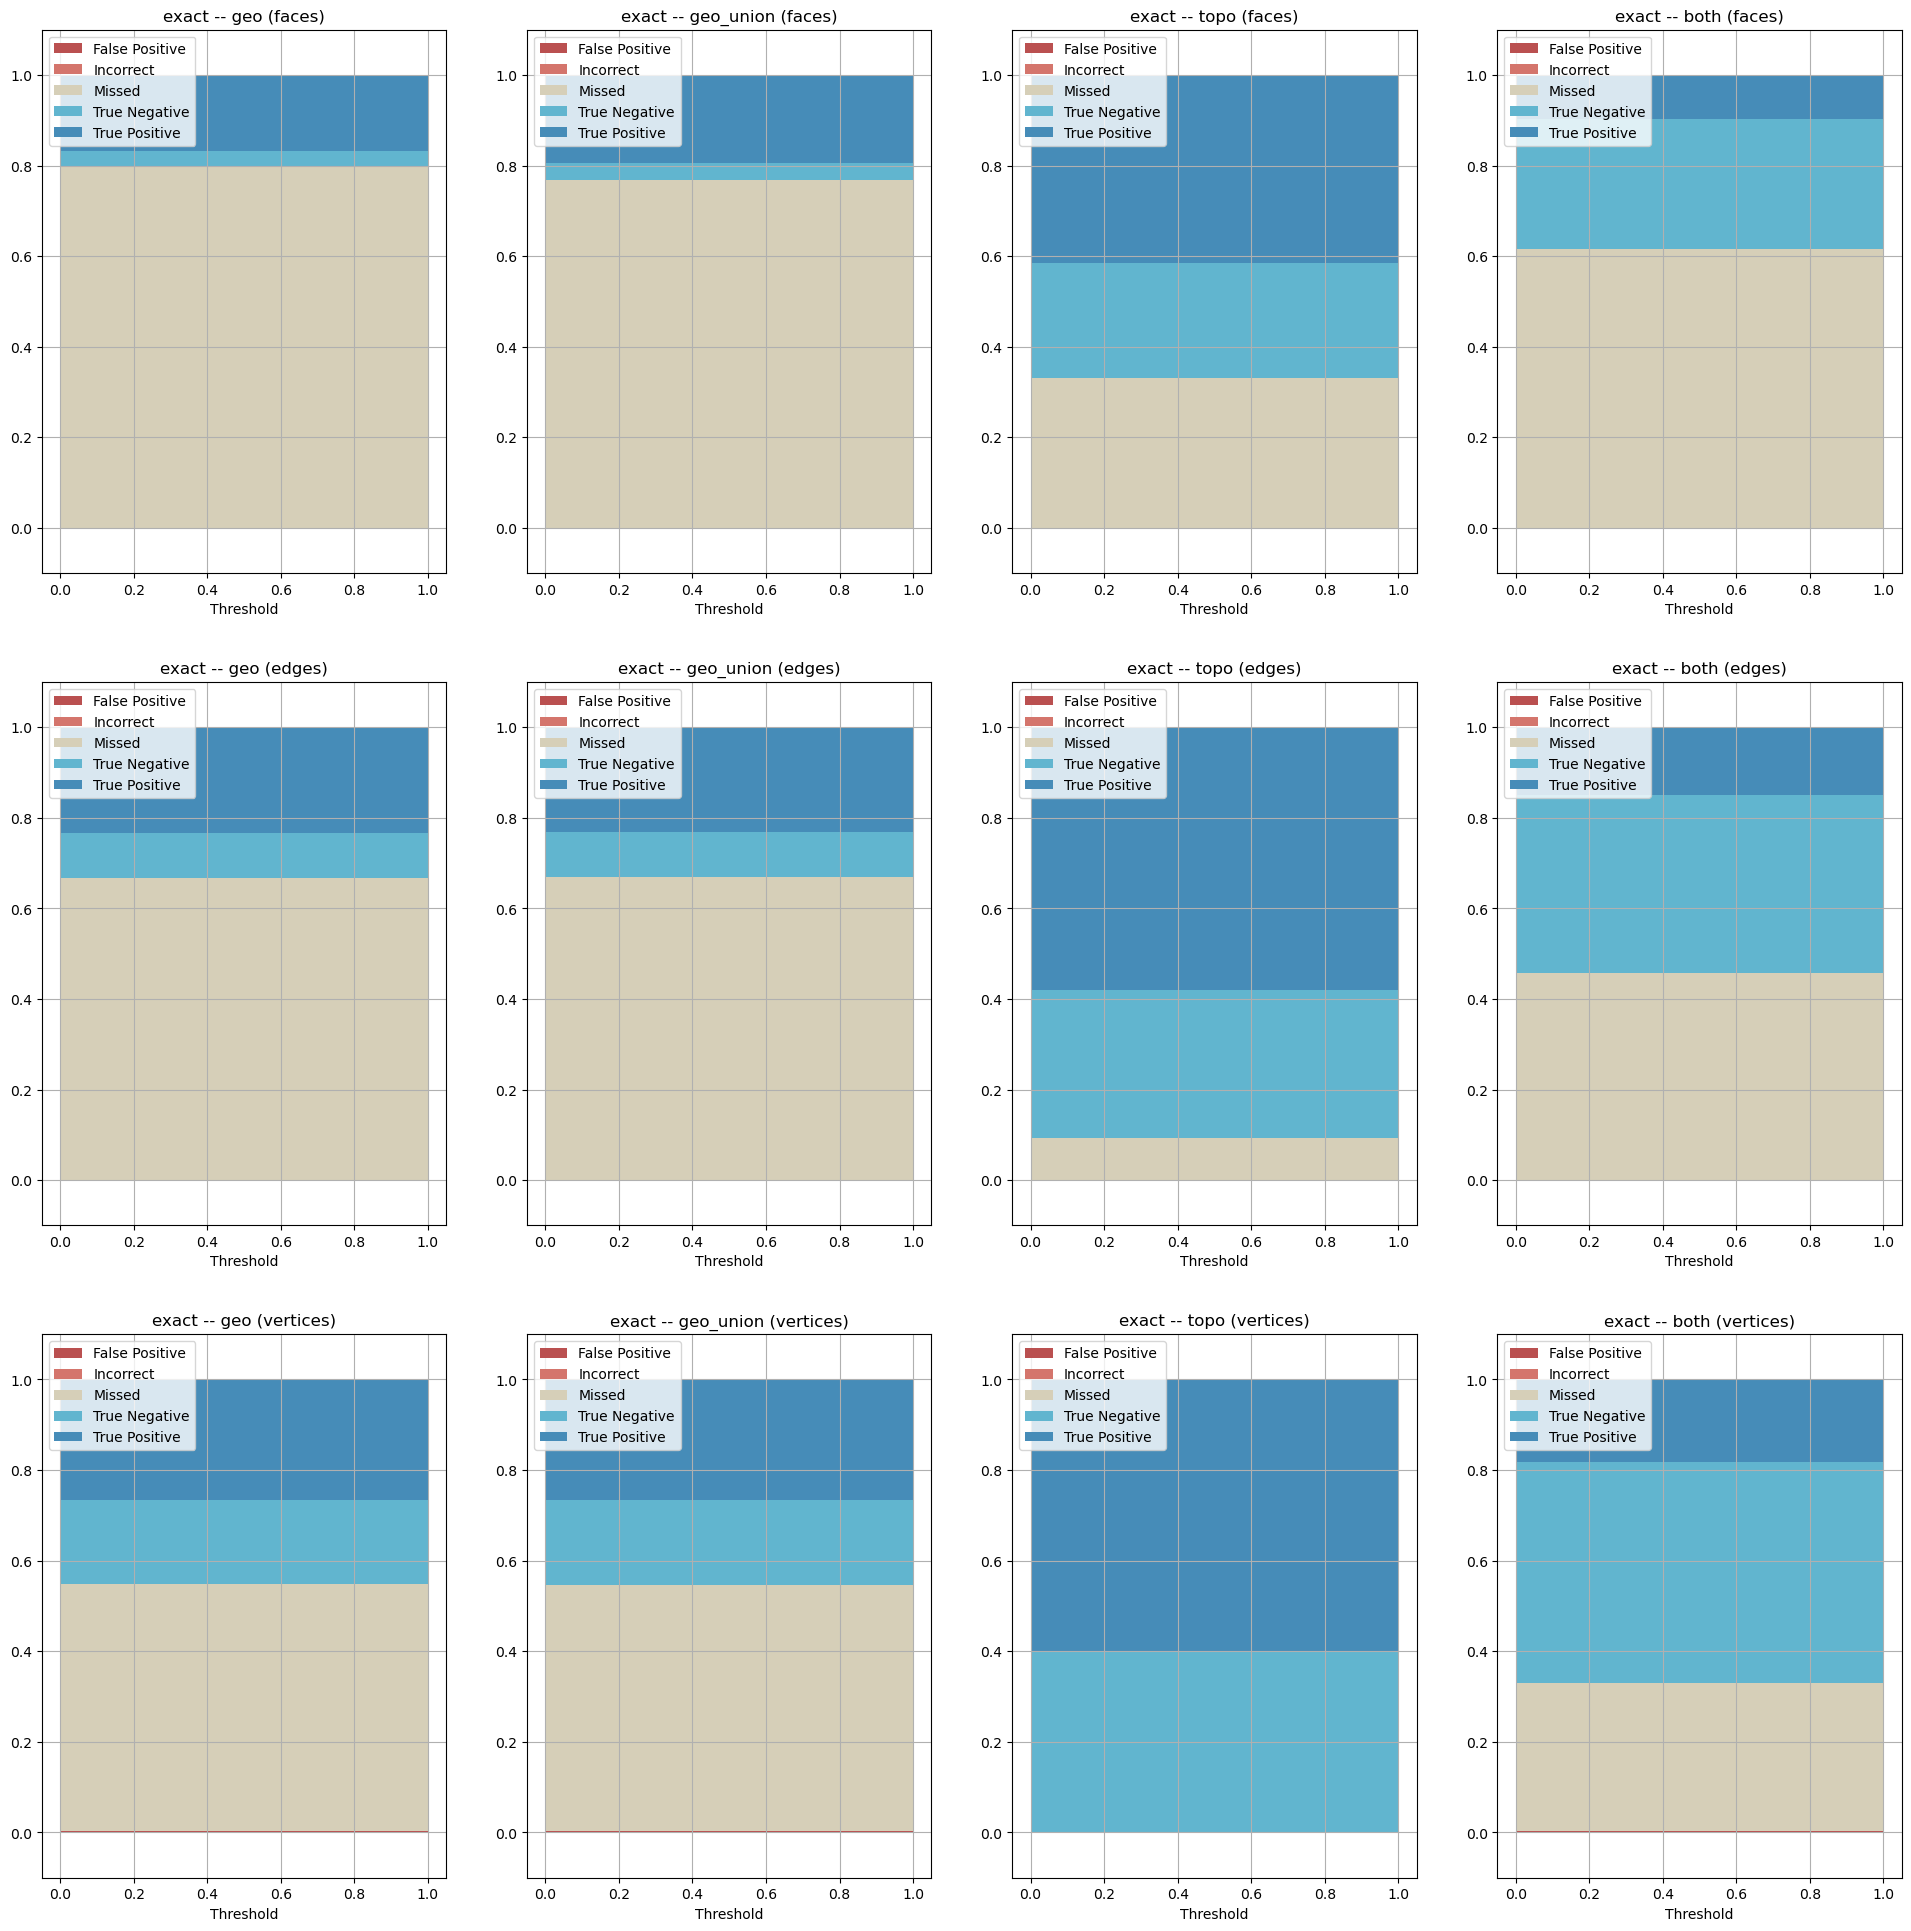

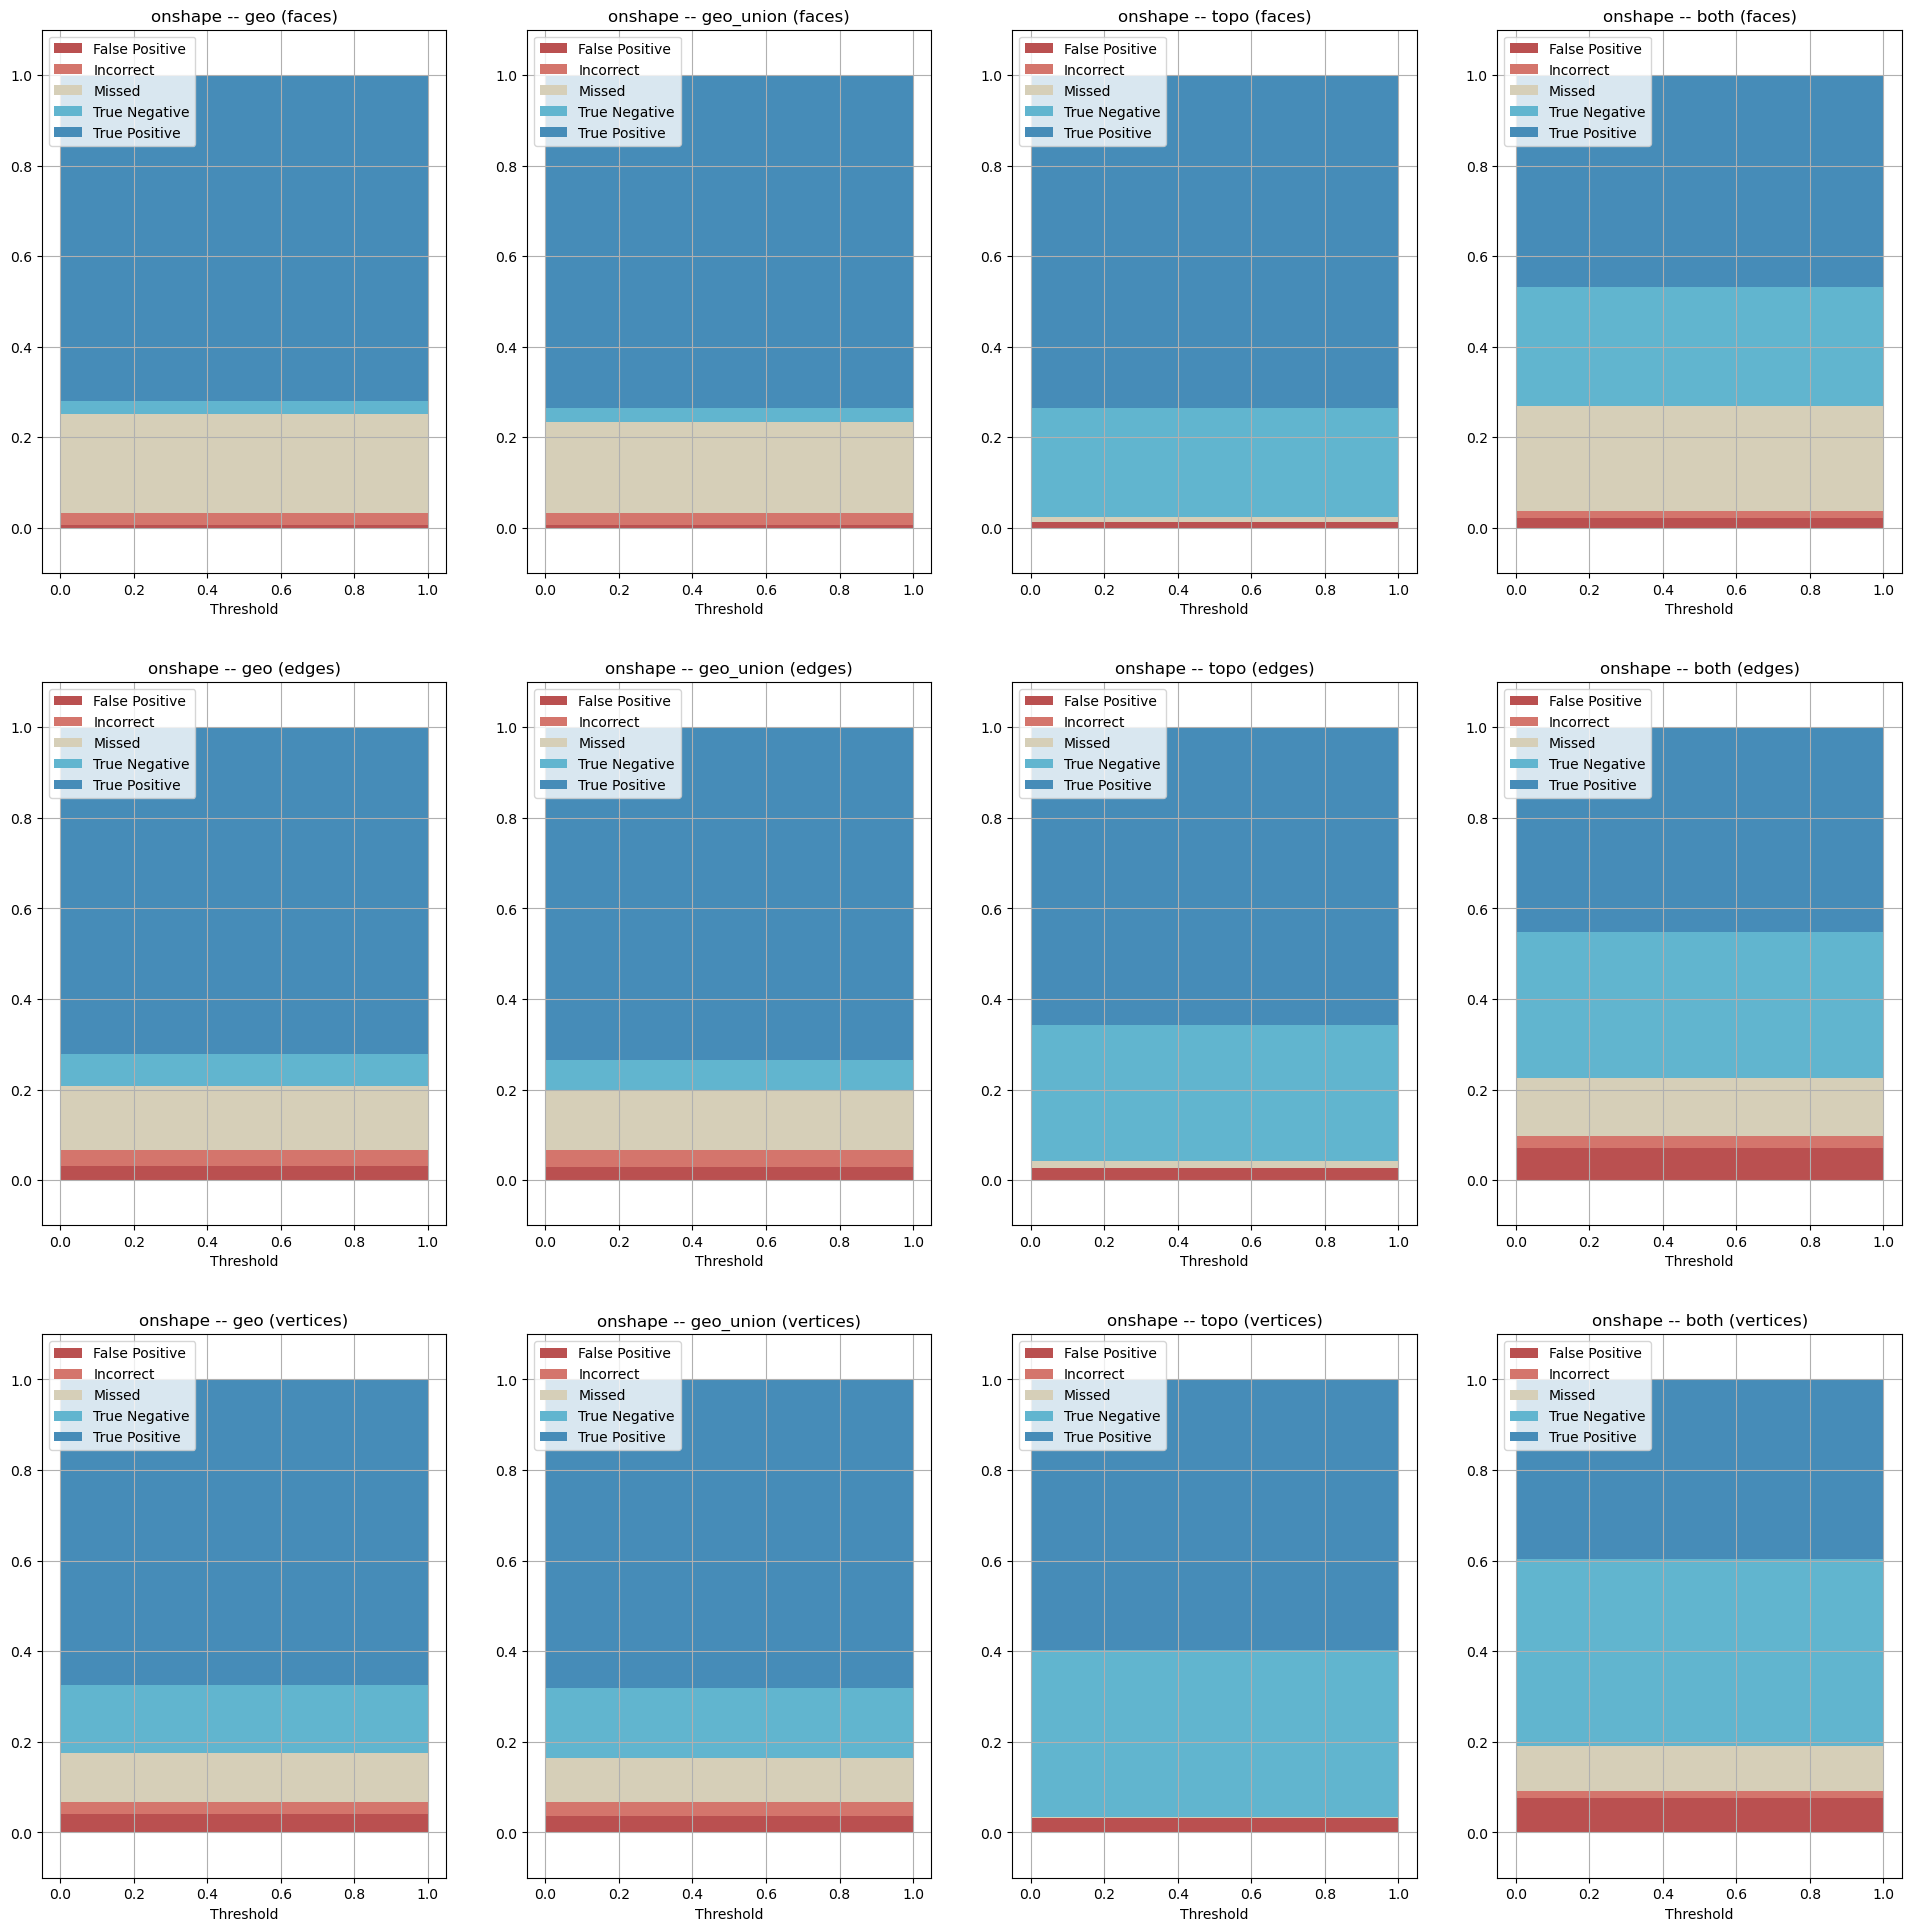

In [17]:
def plot_grid(metrics, method='exact'):
    fig, axes = plt.subplots(3,4, figsize = (24,24))
    for i,ds in enumerate(['geo','geo_union', 'topo','both']):
        for j,t in enumerate(['faces','edges','vertices']):
            m = metrics[ds][method][t]
            plot = plot_the_fives(*np.stack([m]*2)[:,:-2].T, np.array([0.0,1.0]),f'{method} -- {ds} ({t})', ax=axes[j,i])
    return fig
coincidence_fig = plot_grid(all_metrics, 'coincidence')
exact_fig = plot_grid(all_metrics, 'exact')
onshape_fig = plot_grid(all_metrics, 'onshape')

#coincidence_fig.savefig('coincidence_99_99.png')
#exact_fig.savefig('exact_99_99.png')
#onshape_fig.savefig('onshape_99_99.png')
